# **Importing Libraries**

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import kagglehub
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
import torchvision.models.segmentation as segmentation
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader
from glob import glob
from sklearn.model_selection import train_test_split
from tqdm import tqdm


In [3]:
pip install kaggle

In [4]:
!pip install --upgrade torchvision

# **Partial Focal Cross Entropy (pfCE)**

In [5]:
class PartialFocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None):
        super(PartialFocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha   # Class weights if the data is imbalanced

    def forward(self, inputs, targets, labeled_mask):
        """
        inputs: Model predictions (Logits) with dimensions [Batch, Classes, Height, Width]
        targets: The Ground Truth with dimensions [Batch, Height, Width]
        labeled_mask: Binary mask (1 for known pixel, 0 for unknown pixel) with dimensions [Batch, Height, Width]
        """
        #  1. Calculate the standard Cross Entropy for each pixel (without summing)
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)

        # 2. Calculating the probability of the correct class (pt)
        pt = torch.exp(-ce_loss)

        #  3. Calculating the Focal Loss for each pixel
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        #  4. Multiply the result by the mask (to zero out the unknown pixels)
        masked_loss = focal_loss * labeled_mask

        #  5. Sum the error and divide it by the number of known pixels only
        epsilon = 1e-8 #  To avoid division by zero
        final_loss = masked_loss.sum() / (labeled_mask.sum() + epsilon)

        return final_loss

# **Dataset Selection**

In [6]:
from google.colab import userdata

os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

In [7]:
# Download latest version
path = kagglehub.dataset_download("adrianboguszewski/landcoverai")

print("Path to dataset files:", path)

100%|██████████| 1.43G/1.43G [00:16<00:00, 95.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/adrianboguszewski/landcoverai/versions/2


In [8]:
print("The files in the data:")

#  We'll show just the first 10 files as an example so you can make sure the images have downloaded.
count = 0
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        count += 1
        if count == 10:
            break
    if count == 10:
        break

The files in the data:
/root/.cache/kagglehub/datasets/adrianboguszewski/landcoverai/versions/2/val.txt
/root/.cache/kagglehub/datasets/adrianboguszewski/landcoverai/versions/2/split.py
/root/.cache/kagglehub/datasets/adrianboguszewski/landcoverai/versions/2/test.txt
/root/.cache/kagglehub/datasets/adrianboguszewski/landcoverai/versions/2/train.txt
/root/.cache/kagglehub/datasets/adrianboguszewski/landcoverai/versions/2/masks/M-33-32-B-b-4-4.tif
/root/.cache/kagglehub/datasets/adrianboguszewski/landcoverai/versions/2/masks/N-34-66-C-c-4-3.tif
/root/.cache/kagglehub/datasets/adrianboguszewski/landcoverai/versions/2/masks/M-34-77-B-c-2-3.tif
/root/.cache/kagglehub/datasets/adrianboguszewski/landcoverai/versions/2/masks/N-34-140-A-d-3-4.tif
/root/.cache/kagglehub/datasets/adrianboguszewski/landcoverai/versions/2/masks/N-34-97-C-b-1-2.tif
/root/.cache/kagglehub/datasets/adrianboguszewski/landcoverai/versions/2/masks/M-34-65-D-d-4-1.tif


Reading image from: /root/.cache/kagglehub/datasets/adrianboguszewski/landcoverai/versions/2/images/M-33-32-B-b-4-4.tif


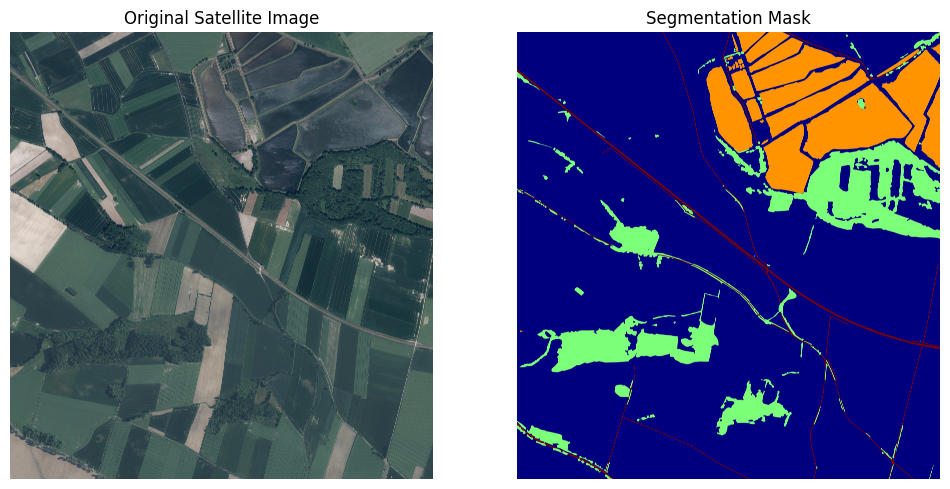

In [ ]:
# The main paths for the images and masks folder
images_dir = os.path.join(path, 'images')
masks_dir = os.path.join(path, 'masks')

# 1. We will get a list of all the file names inside the photos folder and choose the first one.
first_image_filename = os.listdir(images_dir)[0]

# 2. We specify the full path of the image and the mask (the mask always has the same name as the image)
image_path = os.path.join(images_dir, first_image_filename)
mask_path = os.path.join(masks_dir, first_image_filename)

print(f"Reading image from: {image_path}")

# 3.  We read the images
image = cv2.imread(image_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)


if image is None:
    print("There's still a problem with the image path!")
else:

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    #  Show the two pictures
    fig, arr = plt.subplots(1, 2, figsize=(12, 6))
    arr[0].imshow(image)
    arr[0].set_title('Original Satellite Image')
    arr[0].axis('off')

    arr[1].imshow(mask, cmap='jet')
    arr[1].set_title('Segmentation Mask')
    arr[1].axis('off')

    plt.show()

# **Simulating Point Labels**

In [10]:
def simulate_point_labels(mask, num_points_per_class=10, ignore_index=255):
    """
    This function takes the full mask and extracts random points from it only.
    mask: 2D Tensor (Height, Width) representing the Ground Truth.
    num_points_per_class: the number of points we will keep for each class.
    """
    # We make an empty version filled with 255, the same size as the original mask.
    simulated_mask = torch.full_like(mask, ignore_index)

    # We bring all the classes present in this image
    classes = torch.unique(mask)

    for c in classes:
        if c == ignore_index:
            continue

        # We get the locations (coordinates) of all the pixels that belong to class D
        coords = torch.nonzero(mask == c)

        # We make sure that we're not asking for more points than available.
        num_samples = min(num_points_per_class, len(coords))
        if num_samples == 0:
            continue

        #  We choose random points
        random_indices = torch.randperm(len(coords))[:num_samples]
        sampled_coords = coords[random_indices]

        # We put the original class in the random places we chose in the new mask.
        simulated_mask[sampled_coords[:, 0], sampled_coords[:, 1]] = c

    return simulated_mask

#  **Integrating simulation into the Dataset Class**

In [11]:
from torch.utils.data import Dataset

class RemoteSensingDataset(Dataset):
    def __init__(self, images, masks, num_points=10):
        #  Here we assume that you have read the image and mask paths
        self.images = images
        self.masks = masks
        self.num_points = num_points

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Here is the code for reading the image and mask (for example, using cv2 or PIL)
        image = self.read_image(self.images[idx])
        full_mask = self.read_mask(self.masks[idx])

        # Converting them to Tensors
        image_tensor = torch.tensor(image, dtype=torch.float32)
        full_mask_tensor = torch.tensor(full_mask, dtype=torch.long)

        # Simulation application! (This is the required step in the task)
        point_mask = simulate_point_labels(full_mask_tensor, self.num_points)

        return image_tensor, point_mask

# **Segmentation (The Network)**

In [12]:
# Let's assume that the data has 6 classes
NUM_CLASSES = 6

# We are building a DeepLabV3 model with a ResNet50 backbone
model = segmentation.deeplabv3_resnet50(
    weights=None,
    # We are building a DeepLabV3 model with a ResNet50 backbone
    weights_backbone=models.ResNet50_Weights.DEFAULT,
    num_classes=NUM_CLASSES
)

# Definition of the Loss we created in the first step
#  (Assuming you have defined its class in a previous cell)
criterion = PartialFocalLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("The model was built successfully!")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 131MB/s]


The model was built successfully!


# **Preparing the DataLoaders**

In [13]:

# The variable path is the path where the data was downloaded from Kagglehub.
# (The same variable we used at the beginning)
base_dir = path

#  Basic folder paths
images_dir = os.path.join(base_dir, 'images')
masks_dir = os.path.join(base_dir, 'masks')

def get_paths_from_txt(txt_filename):
    #  A function that reads a text file and returns a list of the full paths of images and masks.
    txt_path = os.path.join(base_dir, txt_filename)
    img_paths = []
    mask_paths = []

    with open(txt_path, 'r') as f:
        lines = f.readlines()
        for line in lines:

            name = line.strip()
            if name: #  To make sure the line isn't empty
                img_paths.append(os.path.join(images_dir, name + '.tif' or'.jpg' or '.png'))
                mask_paths.append(os.path.join(masks_dir, name + '.tif' or'.jpg' or '.png'))

    return img_paths, mask_paths

# 1. Extract training image paths and masks
train_images, train_masks = get_paths_from_txt('train.txt')

# 2. Extracting image paths and test masks
test_images, test_masks = get_paths_from_txt('test.txt')

#  (Optional) Extract evaluation (Validation) paths if we need them later
val_images, val_masks = get_paths_from_txt('val.txt')


print(f"Number of training images: {len(train_images)}")
print(f"Number of test images: {len(test_images)}")

Number of training images: 7470
Number of test images: 1602


In [14]:

class RemoteSensingDataset(Dataset):
    def __init__(self, images_paths, masks_paths, num_points):
        self.images = images_paths
        self.masks = masks_paths
        self.num_points = num_points

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # 1.Reading the image and resizing it (to standardize dimensions and avoid memory errors)
        image_path = self.images[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (512, 512)) # Uniform size to 512x512

        # 2. Reading the mask and changing its size (keeping the same size and without messing up the class numbers, we use INTER_NEAREST)
        mask_path = self.masks[idx]
        full_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        full_mask = cv2.resize(full_mask, (512, 512), interpolation=cv2.INTER_NEAREST)

        # 3. Point simulation (creating labeled_mask)
        h, w = full_mask.shape
        labeled_mask = np.zeros((h, w), dtype=np.float32)

        # If the number of points is less than the total number of pixels (meaning we are in the training phase)
        if self.num_points < (h * w):
            random_x = np.random.randint(0, h, self.num_points)
            random_y = np.random.randint(0, w, self.num_points)
            labeled_mask[random_x, random_y] = 1.0
        else:
            # If it's a large number (meaning we're in the Test phase), we mark all the pixels.
            labeled_mask[:, :] = 1.0

        # 4. If it's a large number (meaning we're in the Test phase), we mark all the pixels.
        image_tensor = TF.to_tensor(image)
        # Standard Normalization for ResNet/DeepLabV3 Models
        image_tensor = TF.normalize(image_tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        target_tensor = torch.from_numpy(full_mask).long()
        labeled_mask_tensor = torch.from_numpy(labeled_mask).float()

        return image_tensor, target_tensor, labeled_mask_tensor

In [15]:
# 1.  Definition of the function that extracts paths from text files
base_dir = path # (This variable 'path' is where we downloaded the data from Kagglehub)
images_dir = os.path.join(base_dir, 'images')
masks_dir = os.path.join(base_dir, 'masks')

def get_paths_from_txt(txt_filename):
    txt_path = os.path.join(base_dir, txt_filename)
    img_paths = []
    mask_paths = []
    with open(txt_path, 'r') as f:
        for line in f.readlines():
            name = line.strip()
            if name: #  Make sure the line is not empty
                img_paths.append(os.path.join(images_dir, name + '.tif'))
                mask_paths.append(os.path.join(masks_dir, name + '.tif'))
    return img_paths, mask_paths

# ==========================================
# 2.  Integration with your code: Extracting the real paths
# ==========================================
train_images, train_masks = get_paths_from_txt('train.txt')
test_images, test_masks = get_paths_from_txt('test.txt')

print(f"Training paths have been withdrawn: {len(train_images)} imege")
print(f" The test tracks have been withdrawn: {len(test_images)}imege")

# 3. Creating the Datasets

dataset_train_10_points = RemoteSensingDataset(train_images, train_masks, num_points=10)
dataset_train_50_points = RemoteSensingDataset(train_images, train_masks, num_points=50)

# For the test, we put a big number so it would take all the pixels
dataset_test = RemoteSensingDataset(test_images, test_masks, num_points=1000000)

# 4.DataLoaders
# Let's keep the batch_size = 4 as you wrote, that's an excellent number for memory.
train_loader_10 = DataLoader(dataset_train_10_points, batch_size=4, shuffle=True)
train_loader_50 = DataLoader(dataset_train_50_points, batch_size=4, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=4, shuffle=False)

print("The DataLoaders have been successfully set up!")

Training paths have been withdrawn: 7470 imege
 The test tracks have been withdrawn: 1602imege
The DataLoaders have been successfully set up!


In [16]:
# 1. Automatically check the path (in case Colab forgot the variable)
path = kagglehub.dataset_download("adrianboguszewski/landcoverai")
images_dir = os.path.join(path, 'images')
masks_dir = os.path.join(path, 'masks')

# 2.Pull all the files currently on the hard drive and organize them
# Pull all the files currently on the hard drive and organize them
all_images = sorted(glob(os.path.join(images_dir, '*.tif')))
all_masks = sorted(glob(os.path.join(masks_dir, '*.tif')))


assert len(all_images) > 0, "No images found! Make sure the data is uploaded."
assert len(all_images) == len(all_masks), "The number of images does not match the number of masks!"

# 3.Data split (80% for training and 20% for testing)
train_images, test_images, train_masks, test_masks = train_test_split(
    all_images, all_masks, test_size=0.2, random_state=42
)

print(f"✅ The data has been successfully extracted from the actual files!")
print(f"Number of training images: {len(train_images)}")
print(f"Number of test images: {len(test_images)}")

# 4. Recreating the Datasets (using your class)
dataset_train_10_points = RemoteSensingDataset(train_images, train_masks, num_points=10)
dataset_train_50_points = RemoteSensingDataset(train_images, train_masks, num_points=50)
dataset_test = RemoteSensingDataset(test_images, test_masks, num_points=1000000)

# 5. Recreating the DataLoaders
train_loader_10 = DataLoader(dataset_train_10_points, batch_size=4, shuffle=True)
train_loader_50 = DataLoader(dataset_train_50_points, batch_size=4, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=4, shuffle=False)

print("The DataLoaders are all set and loaded with images!")

Using Colab cache for faster access to the 'landcoverai' dataset.
✅ The data has been successfully extracted from the actual files!
Number of training images: 32
Number of test images: 9
The DataLoaders are all set and loaded with images!


# **The Training Loop**

In [17]:

def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0

        # We use tqdm to monitor the training progress
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for batch in progress_bar:
            # Extracting data from the patch
            images, true_masks, labeled_masks = batch

            # Transfer data to the graphics card
            images = images.to(device)
            true_masks = true_masks.to(device)
            labeled_masks = labeled_masks.to(device)

            # Resetting the Gradients
            optimizer.zero_grad()

            # Forward Pass
            outputs = model(images)['out']

            # Calculating the loss (using your function that takes 3 variables)
            loss = criterion(outputs, true_masks, labeled_masks)

            # Update (Backward pass)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            progress_bar.set_postfix({'Loss': loss.item()})

        print(f"Average Epoch Loss: {epoch_loss/len(train_loader):.4f}\n")

    return model

# **Evaluation - mIoU**
      We will build two models, train the first on the 10-point data, and train the second on the 50-point data, and then compare them!

In [84]:
# 2. Basic experiment settings
# ==========================================
NUM_CLASSES = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Using your loss function
criterion = PartialFocalLoss()

# ==========================================
# First experiment: Training on only 10 points
# ==========================================
print("---Start the first experiment (10 points)---")
model_10 = segmentation.deeplabv3_resnet50(
    weights=None,
    weights_backbone=models.ResNet50_Weights.DEFAULT,
    num_classes=NUM_CLASSES
)
optimizer_10 = torch.optim.Adam(model_10.parameters(), lr=0.001)

#  Training
model_10 = train_model(model_10, train_loader_10, criterion, optimizer_10, num_epochs=5)

#  Evaluation
miou_10 = evaluate_model(model_10, test_loader, NUM_CLASSES)
print(f"🎯 Test mIoU for 10 points: {miou_10:.4f}\n")


# ==========================================
# Second experiment: Training on 50 points
# ==========================================
print("---Start of the second experiment (50 points)---")
model_50 = segmentation.deeplabv3_resnet50(
    weights=None,
    weights_backbone=models.ResNet50_Weights.DEFAULT,
    num_classes=NUM_CLASSES
)
optimizer_50 = torch.optim.Adam(model_50.parameters(), lr=0.001)

# Training
model_50 = train_model(model_50, train_loader_50, criterion, optimizer_50, num_epochs=5)

# Evaluation
miou_50 = evaluate_model(model_50, test_loader, NUM_CLASSES)
print(f"🎯 Test mIoU for 50 points: {miou_50:.4f}\n")

--- بدء التجربة الأولى (10 نقاط) ---


Epoch 1/5: 100%|██████████| 8/8 [13:29<00:00, 101.17s/it, Loss=0.703]


Average Epoch Loss: 1.0662



Epoch 2/5: 100%|██████████| 8/8 [12:39<00:00, 94.88s/it, Loss=0.906]


Average Epoch Loss: 0.8185



Epoch 3/5: 100%|██████████| 8/8 [12:38<00:00, 94.83s/it, Loss=0.708]


Average Epoch Loss: 0.5349



Epoch 4/5: 100%|██████████| 8/8 [12:44<00:00, 95.53s/it, Loss=0.294]


Average Epoch Loss: 0.4160



Epoch 5/5: 100%|██████████| 8/8 [12:39<00:00, 94.91s/it, Loss=0.504]


Average Epoch Loss: 0.4107

🎯 Test mIoU for 10 points: 0.2924

--- بدء التجربة الثانية (50 نقطة) ---


Epoch 1/5: 100%|██████████| 8/8 [12:58<00:00, 97.27s/it, Loss=0.693]


Average Epoch Loss: 1.0168



Epoch 2/5: 100%|██████████| 8/8 [13:06<00:00, 98.37s/it, Loss=0.776]


Average Epoch Loss: 0.5823



Epoch 3/5: 100%|██████████| 8/8 [13:00<00:00, 97.56s/it, Loss=0.671]


Average Epoch Loss: 0.4107



Epoch 4/5: 100%|██████████| 8/8 [12:51<00:00, 96.42s/it, Loss=0.46]


Average Epoch Loss: 0.4006



Epoch 5/5: 100%|██████████| 8/8 [12:48<00:00, 96.02s/it, Loss=0.235]


Average Epoch Loss: 0.3123

🎯 Test mIoU for 50 points: 0.3868



#**Visual Comparison**

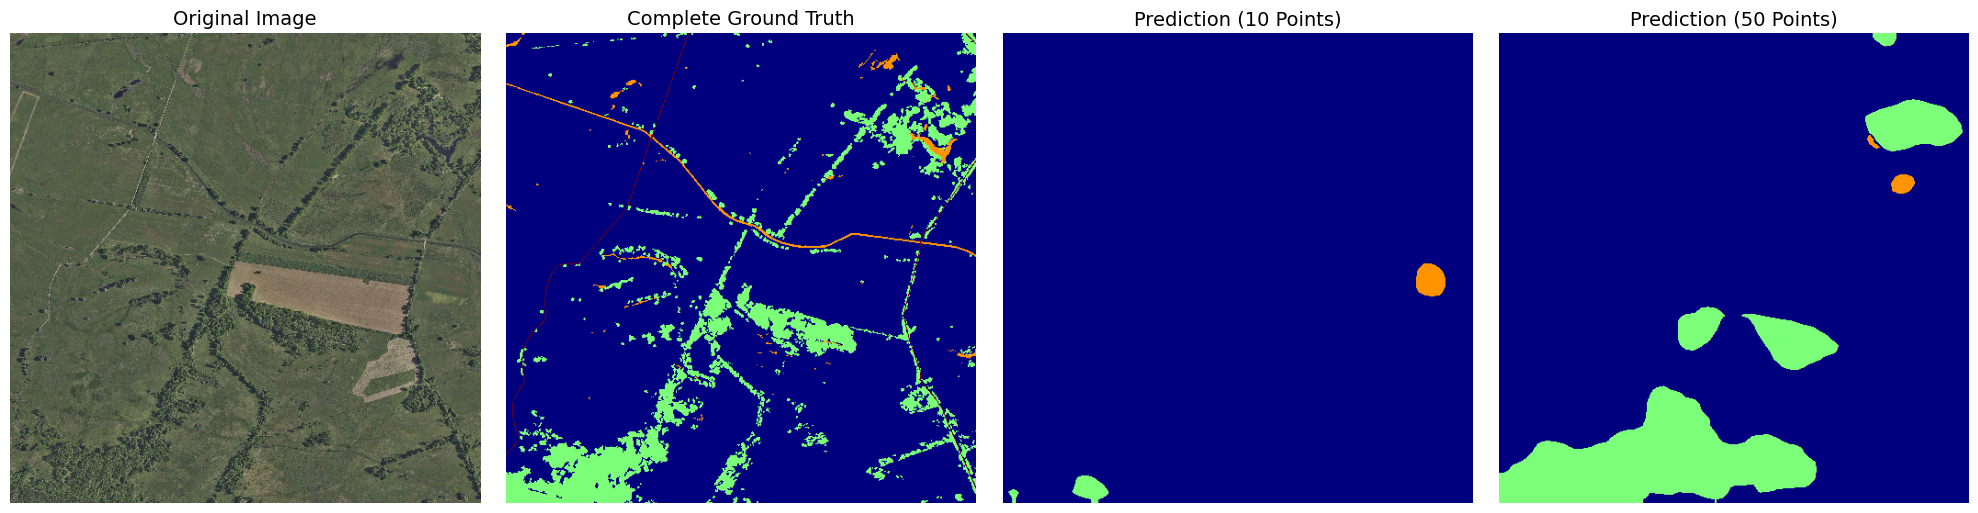

In [86]:

def visualize_predictions(model_10, model_50, test_loader, NUM_CLASSES=5):
    # Ensure we are using the correct device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Transfer the models to the graphics card (to check)
    model_10 = model_10.to(device)
    model_50 = model_50.to(device)

    # Set models to evaluation mode
    model_10.eval()
    model_50.eval()

    # -----------------------------------------------------
    #  The modification here: add _ to accept the dot mask and ignore it
    # -----------------------------------------------------
    images, true_masks, _ = next(iter(test_loader))

    # Select the first image and mask
    image = images[0].to(device)
    true_mask = true_masks[0].cpu().numpy()

    # Inference (Predictions)
    with torch.no_grad():
        input_image = image.unsqueeze(0)

        out_10 = model_10(input_image)['out']
        pred_10 = torch.argmax(out_10, dim=1).squeeze(0).cpu().numpy()

        out_50 = model_50(input_image)['out']
        pred_50 = torch.argmax(out_50, dim=1).squeeze(0).cpu().numpy()

    # -----------------------------------------------------
    # Preparing the image for drawing (removing normalization so the colors look correct)
    # -----------------------------------------------------
    img_display = image.cpu().permute(1, 2, 0).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_display = std * img_display + mean
    img_display = np.clip(img_display, 0, 1) #  Make sure the values are between 0 and 1

    # Plotting
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    axes[0].imshow(img_display)
    axes[0].set_title('Original Image', fontsize=14)
    axes[0].axis('off')

    axes[1].imshow(true_mask, cmap='jet', vmin=0, vmax=NUM_CLASSES-1)
    axes[1].set_title('Complete Ground Truth', fontsize=14)
    axes[1].axis('off')

    axes[2].imshow(pred_10, cmap='jet', vmin=0, vmax=NUM_CLASSES-1)
    axes[2].set_title('Prediction (10 Points)', fontsize=14)
    axes[2].axis('off')

    axes[3].imshow(pred_50, cmap='jet', vmin=0, vmax=NUM_CLASSES-1)
    axes[3].set_title('Prediction (50 Points)', fontsize=14)
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()

# Run the function
visualize_predictions(model_10, model_50, test_loader, NUM_CLASSES=5)

Save Model

In [ ]:
torch.save(model_50.state_dict(), 'model_50.pth')